# Optimal Learning Rate 찾기 및 Huber Loss 함수 적용

손실 함수는 크게 분류 및 회귀 손실의 두 가지 유형으로 분류 할 수 있습니다. Huber Loss는 회귀 손실에 속합니다. Huber 손실은 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다. 

<img src="https://blog.kakaocdn.net/dn/081sh/btqNth1n6DL/rkSLdrV0RFuYg04k4VyeZK/img.png" width=300/>

$$L_{\delta}(y, f(x))= \begin{cases}
    \frac{1}{2}(y-f(x))^2       & \quad \text{ for |y-f(x)|} \leq \delta,\\
   \delta |y-f(x)|-\frac{1}{2} \delta^2  & \quad \text{if } n \text{ is odd}
  \end{cases}$$  
  
- Huber function은 모든 구간에서 미분가능하고 연속  
- $\delta$로 경사도 조절

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [2]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [4]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [5]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [6]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (16, 20)
y =  (16,)


## Stacked + Bidirectoinal LSTM

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
    return model

### Optimal Learning Rate 찾기

- epoch이 진행되면서 Learning Rate를 증가시킴  

- loss가 감소하다 증가하는 경우 learning rate를 시각화 하여 loss 증가 직전의 가장 큰 learning rate 선택  

- 선택한 learning rate 로 다시 train

In [8]:
model = create_model()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler( 
                                        lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
27/27 [==============================] - 5s 14ms/step - loss: 74.5907 - mae: 75.0885
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 73.6842 - mae: 74.1824
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 72.8039 - mae: 73.3002
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 72.0701 - mae: 72.5683
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 71.4568 - mae: 71.9551
Epoch 6/100
27/27 [==============================] - 0s 13ms/step - loss: 70.9040 - mae: 71.4027
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 70.3589 - mae: 70.8585
Epoch 8/100
27/27 [==============================] - 0s 13ms/step - loss: 69.8238 - mae: 70.3238
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 69.2373 - mae: 69.7365
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 68.5886 - mae: 69.0864
Epoch 11/100
27/27 [=========

27/27 [==============================] - 0s 12ms/step - loss: 45.4870 - mae: 45.9841
Epoch 85/100
27/27 [==============================] - 0s 13ms/step - loss: 46.2613 - mae: 46.7603
Epoch 86/100
27/27 [==============================] - 0s 12ms/step - loss: 55.7684 - mae: 56.2676
Epoch 87/100
27/27 [==============================] - 0s 13ms/step - loss: 45.6765 - mae: 46.1737
Epoch 88/100
27/27 [==============================] - 0s 12ms/step - loss: 53.5366 - mae: 54.0346
Epoch 89/100
27/27 [==============================] - 0s 12ms/step - loss: 52.9486 - mae: 53.4476
Epoch 90/100
27/27 [==============================] - 0s 12ms/step - loss: 57.4207 - mae: 57.9190
Epoch 91/100
27/27 [==============================] - 0s 12ms/step - loss: 55.0562 - mae: 55.5546
Epoch 92/100
27/27 [==============================] - 0s 13ms/step - loss: 51.4141 - mae: 51.9123
Epoch 93/100
27/27 [==============================] - 0s 12ms/step - loss: 53.6073 - mae: 54.1070
Epoch 94/100
27/27 [=============

- loss 시각화

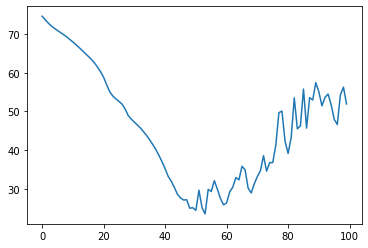

In [9]:
plt.plot(history.history['loss'])

### learning rate에 따른 loss 시각화 

x 축에 learning rate (`history.history['lr']`), y축에 `loss` 를 시각화  

plt.axis(xmin, xmax, ymin, ymax)

(1e-07, 0.0001, 20.0, 70.0)

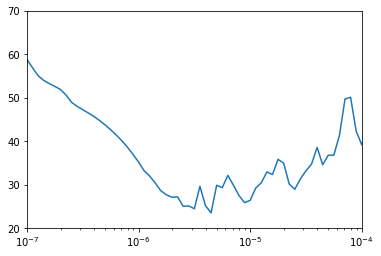

In [10]:
plt.semilogx(history.history['lr'], history.history['loss'])

plt.axis([1e-7, 1e-4, 20, 70])

In [14]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

best_lr = np.array(history.history['lr'])[idx]
best_lr

array([4.466836e-06], dtype=float32)

### model re-train

최적의 learning rate를 이용하여 model retrain

In [15]:
model = create_model()

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100)

Epoch 1/100
27/27 [==============================] - 6s 14ms/step - loss: 70.2140 - mae: 70.7125
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 52.2757 - mae: 52.7729
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 48.6078 - mae: 49.1066
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 45.0567 - mae: 45.5549
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 41.4489 - mae: 41.9459
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 38.2791 - mae: 38.7766
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 35.8207 - mae: 36.3189
Epoch 8/100
27/27 [==============================] - 0s 13ms/step - loss: 34.2028 - mae: 34.7006
Epoch 9/100
27/27 [==============================] - 0s 14ms/step - loss: 32.6063 - mae: 33.1051
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 31.6322 - mae: 32.1291
Epoch 11/100
27/27 [=========

27/27 [==============================] - 0s 14ms/step - loss: 19.7033 - mae: 20.1932
Epoch 85/100
27/27 [==============================] - 0s 14ms/step - loss: 20.3410 - mae: 20.8323
Epoch 86/100
27/27 [==============================] - 0s 14ms/step - loss: 21.3770 - mae: 21.8694
Epoch 87/100
27/27 [==============================] - 0s 14ms/step - loss: 21.6800 - mae: 22.1732
Epoch 88/100
27/27 [==============================] - 1s 17ms/step - loss: 21.1440 - mae: 21.6389
Epoch 89/100
27/27 [==============================] - 0s 15ms/step - loss: 21.0253 - mae: 21.5188
Epoch 90/100
27/27 [==============================] - 0s 16ms/step - loss: 19.7610 - mae: 20.2543
Epoch 91/100
27/27 [==============================] - 0s 15ms/step - loss: 20.3723 - mae: 20.8631
Epoch 92/100
27/27 [==============================] - 0s 14ms/step - loss: 20.0960 - mae: 20.5917
Epoch 93/100
27/27 [==============================] - 0s 15ms/step - loss: 19.2430 - mae: 19.7387
Epoch 94/100
27/27 [=============

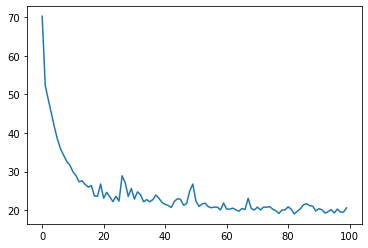

In [16]:
plt.plot(history.history['loss'])

In [17]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size: time].reshape(1, -1))
    forecast.append(prediction[0][0])
    
len(forecast)

50

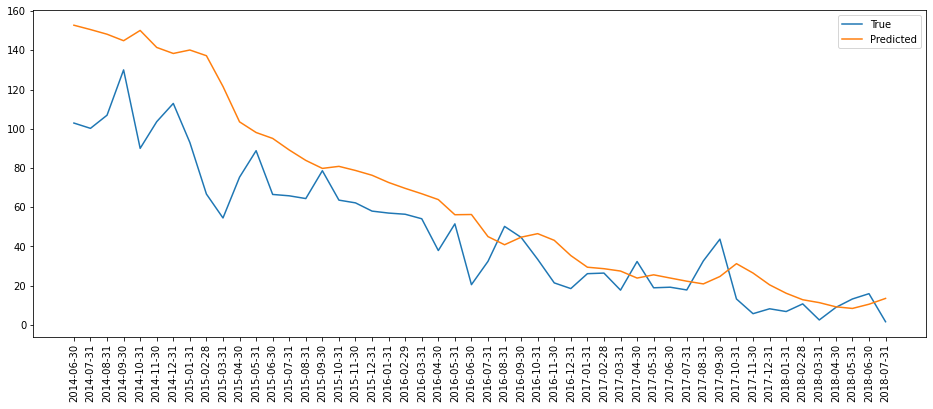

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test, forecast, label='Predicted')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [19]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

672.639
19.44327
